# TechLab - Portfolio Optimization Pt.3

Nel terzo laboratorio applicheremo un'ottimizzazione di portafoglio attraverso l'uso di una rete neurale seguendo quattro fasi:
1. Download e preparazione dei dati
2. Definition della rete neurale
3. Addestramento
4. Valutazione e visualizzazione dei risultati

In [1]:
%matplotlib inline
from deepdow.benchmarks import Benchmark, OneOverN, Random
from deepdow.callbacks import EarlyStoppingCallback
from deepdow.data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale
from deepdow.data.synthetic import sin_single
from deepdow.experiments import Run
from deepdow.layers import SoftmaxAllocator
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap
from deepdow.utils import raw_to_Xy
import matplotlib.pyplot as plt
import numpy as np
import torch
import datetime
import pandas as pd
import pandas_datareader.data as web
from pypfopt import expected_returns

Al fine di rendere i risultati riproducibili fissiamo il seed per `numpy` e `torch`.

In [2]:
torch.manual_seed(4)
np.random.seed(5)

## Caricamento e preparazione del dataset


In [3]:
start = datetime.datetime(2015, 1, 1) 
end = datetime.datetime(2020, 12, 31)

tickers = ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOG']
raw_df = web.DataReader(tickers, 'yahoo', start=start, end=end)[['Adj Close']]

In [4]:
raw_df.columns = pd.MultiIndex.from_product([['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOG'], ['Adj Close']], names=['Ticker', 'Attribute'])

In [5]:
assert isinstance(raw_df, pd.DataFrame)
assert isinstance(raw_df.index, pd.DatetimeIndex)
assert isinstance(raw_df.columns, pd.MultiIndex)

In [6]:
n_timesteps = len(raw_df)  
n_channels = len(raw_df.columns.levels[1])  
n_assets = len(raw_df.columns.levels[0])

In [7]:
print('Timesteps = '+ str(n_timesteps))
print('Channels = '+ str(n_channels))
print('Assets = '+ str(n_assets))

Timesteps = 1511
Channels = 1
Assets = 5


In [8]:
lookback, gap, horizon = 60, 1, 30

In [9]:
X, timestamps, y, asset_names, indicators = raw_to_Xy(raw_df,
                                                      lookback=lookback,
                                                      gap=gap,
                                                      freq="B",
                                                      horizon=horizon)

In [10]:
n_samples = n_timesteps - lookback - horizon - gap 
n_samples

1420

In [11]:
split_ix = int(n_samples * 0.8)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + lookback + horizon, n_samples))

print('Train range: {}:{}\nTest range: {}:{}'.format(indices_train[0], indices_train[-1],
                                                     indices_test[0], indices_test[-1]))

Train range: 0:1135
Test range: 1226:1419


Procediamo alla costruzione del `InRAMDataset` per lo stream dei dati.

In [12]:
dataset = InRAMDataset(X, y, timestamps=timestamps, asset_names=asset_names)

X_sample, y_sample, timestamp_sample, asset_names = dataset[0]

Usando l'oggetto `dataset` possiamo costruire due dataloaders, uno per il training e l'altro per il test.

In [13]:
dataloader_train = RigidDataLoader(dataset,
                                   indices=indices_train,
                                   batch_size=32)

dataloader_test = RigidDataLoader(dataset,
                                  indices=indices_test,
                                  batch_size=32)

## Definizione del network

In [14]:
class GreatNet(torch.nn.Module, Benchmark):
    def __init__(self, n_assets, lookback, p=0.5):
        super().__init__()

        n_features = n_assets * lookback

        self.dropout_layer = torch.nn.Dropout(p=p)
        self.dense_layer = torch.nn.Linear(n_features, n_assets, bias=True)
        self.allocate_layer = SoftmaxAllocator(temperature=None)
        self.temperature = torch.nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        """Perform forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Of shape (n_samples, 1, lookback, n_assets).

        Returns
        -------
        weights : torch.Torch
            Tensor of shape (n_samples, n_assets).

        """
        n_samples, _, _, _ = x.shape
        x = x.view(n_samples, -1)  # flatten features
        x = self.dropout_layer(x)
        x = self.dense_layer(x)

        temperatures = torch.ones(n_samples).to(device=x.device, dtype=x.dtype) * self.temperature
        weights = self.allocate_layer(x, temperatures)

        return weights

Che cosa fa il network? Sotto l'assunzione che gli asset ed il lookback non cambino mai, prende in input il tensore delle feature `x` e produce un vettore di lunghezza `n_assets`. Poiché gli elementi di questo vettore possono variare da $-\infty$
a $+\infty$, lo trasformiamo in una asset allocation con il `SoftmaxAllocator`.
Inoltre, la rappresentazione termografica `temperature` ci permetterà di comprendere il trade-off ottimo tra una allocazione uniforme o una specifica per singolo asset.

In [15]:
network = GreatNet(n_assets, lookback)
print(network)

GreatNet(
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (dense_layer): Linear(in_features=300, out_features=5, bias=True)
  (allocate_layer): SoftmaxAllocator(
    (layer): Softmax(dim=1)
  )
)


Nella libreria `torch`, i networks sono o nello stato **train** o in quello **eval**. Poiché per ridurre il rischio di overfitting utilizzeremo la tecnica del *dropout*, è essenziale che lo stato venga impostato correttamente sulla base di ciò che si sta cercando di fare.

In [16]:
network = network.train()

## Training
E' tempo di definire la nostra funzione di perdita (loss function). E' possibile definire più obiettivi contemporaneamente: possiamo ad esempio voler massimizzare il rendimento atteso, massimizzare lo Sharpe Ratio e minimizzare i drawdowns. Tutte queste funzioni di perdita sono implementate nella funzionalità `deepdow.losses` e, per evitare possibili fraintendimenti, sono tutte definite in modo che **più è basso il valore delle funzioni di perdita, meglio è**. Per combinare più obiettivi è sufficidnte sommare le singole funzioni di perdita. Similarmente, se si vuole assegnare più importanza ad una di loro è sufficiente moltiplicarla per uno scalare.

In [17]:
loss = MaximumDrawdown() + 2 * MeanReturns() + SharpeRatio()

Di default tutte le funzioni di perdita assumono come imput returns logaritmici (`input_type='log'`) che abbiamo memorizzato nel canale 0 (:code:`returns_channel=0`).



Abbiamo ora tutti gli ingredienti pronti per addestrare la rete neurale. `deepdow` dispone del wrapper `Run` che implementa il loop di addestramento e un minimo framework di callback.

In [18]:
run = Run(network,
          loss,
          dataloader_train,
          val_dataloaders={'test': dataloader_test},
          optimizer=torch.optim.Adam(network.parameters(), amsgrad=True),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=15)])

Per avviare il loop di attestramento usiamo `launch` specificando il numero di epoche.

In [19]:
history = run.launch(30)

Epoch 0:   0%|          | 0/36 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(
Epoch 29: 100%|██████████| 36/36 [00:00<00:00, 98.11it/s, loss=-0.06990, test_loss=-0.08371] 


## Valutazione e visualizzazione
L'oggetto `history` restituito da `launch` contiene diverse informazioni utili relative all'addestramento. In particolare, la proprietà `metrics` restituisce un Pandas Dataframe `pd.DataFrame` estremamente dettagliato.
Per mostrare la media della perdita di test per ogni epoca possiamo lanciare il seguente codice:

In [20]:
per_epoch_results = history.metrics.groupby(['dataloader', 'metric', 'model', 'epoch'])['value']

print(per_epoch_results.count())  # double check number of samples each epoch
print(per_epoch_results.mean())  # mean loss per epoch

dataloader  metric  model    epoch
test        loss    network  0        194
                             1        194
                             2        194
                             3        194
                             4        194
                             5        194
                             6        194
                             7        194
                             8        194
                             9        194
                             10       194
                             11       194
                             12       194
                             13       194
                             14       194
                             15       194
                             16       194
                             17       194
                             18       194
                             19       194
                             20       194
                             21       194
                             22       194

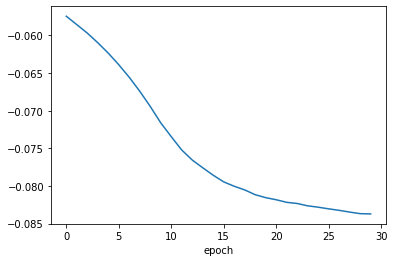

In [21]:
per_epoch_results.mean()['test']['loss']['network'].plot()

Per avere qualche insight in più su ciò che il nostro network prevede, possiamo usare il modulo `deepdow.visualize`.
Prima di cominciare, però, è necessario settare il network nella modalità *eval*.

In [22]:
network = network.eval()

Per avere un contesto per valutare le performance del network, può essere utile utilizzare dei benchmark e `deepdow` ne implementa alcuni. In più, possono esserne definiti di nuovi in modo personalizzato.

In [23]:
benchmarks = {
    '1overN': OneOverN(),  # each asset has weight 1 / n_assets
    'random': Random(),  # random allocation that is however close 1OverN
    'network': network
}

Durante l'addestramento, l'unica metrica/perdita obbligatoria è quella associata alla funzione di perdita che cerchiamo di minimizzare ma ovviamente si può essere interessati a visualizzarne molte altre, come da esempio seguente.

In [24]:
metrics = {
    'MaxDD': MaximumDrawdown(),
    'Sharpe': SharpeRatio(),
    'MeanReturn': MeanReturns()
}

Utilizziamo ora gli oggetti creati: anzitutto creiamo una tabella con tutte le metriche per tutti i campioni e per tutti i benchmark. Questo può essere fatto con la funzione `generate_metrics_table`.

In [25]:
metrics_table = generate_metrics_table(benchmarks,
                                       dataloader_test,
                                       metrics)

E poi possiamo rappresentarla con `plot_metrics`.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5910c23fd0>,
      dtype=object)

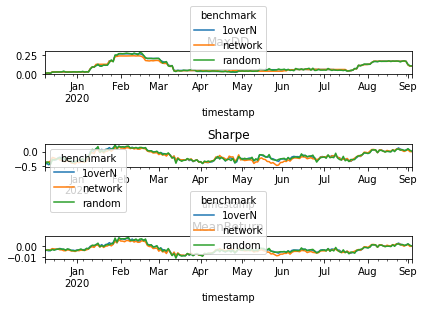

In [26]:
plot_metrics(metrics_table)

Each plot represents a different metric. The x-axis represents the timestamps in our
test set. The different colors are capturing different models. How is the value of a metric
computed? We assume that the investor predicts the portfolio at time x and buys it. He then
holds it for :code:`horizon` timesteps. The actual metric is then computed over this time horizon.



Finally, we are also interested in how the allocation/prediction looks like at each time step.
We can use the :code:`generate_weights_table` function to create a :code:`pd.DataFrame`.



In [27]:
weight_table = generate_weights_table(network, dataloader_test)
weight_table

,AAPL,AMZN,FB,GOOG,NFLX
2019-12-09,0.209574,0.612394,0.044057,0.066511,0.067463
2019-12-10,0.239664,0.552265,0.049426,0.075303,0.083343
2019-12-11,0.233795,0.583635,0.042125,0.067389,0.073055
2019-12-12,0.240172,0.558058,0.052741,0.067677,0.081351
2019-12-13,0.249798,0.545203,0.045370,0.069586,0.090044
...,...,...,...,...,...
2020-08-28,0.243006,0.570652,0.044345,0.057297,0.084700
2020-08-31,0.266655,0.535657,0.040804,0.054294,0.102590
2020-09-01,0.210061,0.635070,0.042023,0.047166,0.065680
2020-09-02,0.215683,0.626689,0.036406,0.035316,0.085907


We then call the :code:`plot_weight_heatmap` to see a heatmap of weights.



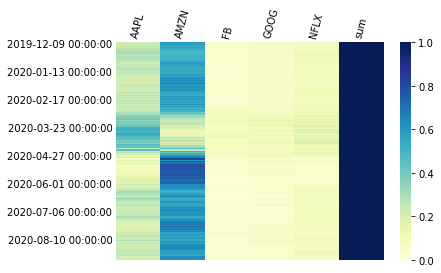

In [28]:
plot_weight_heatmap(weight_table,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=25)

The rows represent different timesteps in our test set. The columns are all the assets in our
universe. The values represent the weight in the portfolio. Additionally, we add a sum column
to show that we are really generating valid allocations.



In [29]:
assets = weight_table.tail(1).columns.to_list()
del assets[-1]
weights = weight_table.tail(1).values
weights = np.delete(weights, -1)
stockStartDate = '2015-01-01'
stockEndDate = '2020-12-31'
df = pd.DataFrame()
for stock in assets:
    df[stock] = web.DataReader(stock, data_source='yahoo', start = stockStartDate, end = stockEndDate)['Adj Close']
returns = expected_returns.returns_from_prices(df).dropna()
portfolioSimpleAnnualReturn = np.sum(returns.mean() * weights) * 252
cov_matrix_annual = returns.cov()*252
port_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
port_volatility = np.sqrt(port_variance)
percent_var = str(round(port_variance, 2)*100) + '%'
percent_vols = str(round(port_volatility, 2)*100) + '%'
percent_ret = str(round(portfolioSimpleAnnualReturn, 2)*100) + '%'

print('Ritorno annuo atteso: '+ percent_ret)
print('Volatilità annua: ' + percent_vols)
print('Varianza annua: ' + percent_var)

Ritorno annuo atteso: 40.0%
Volatilità annua: 27.0%
Varianza annua: 7.000000000000001%
